In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
def curve_rayleigh(t,scale1=0.4,scale2 = .25,val=30,offset=10):
    return 30*(t / scale1**2) * np.exp(-t**2 / (2 * scale2**2))+offset

### First generate a simulated bearing failure signal following: 

#### $y(k)=\sum_{r}A_r\sin\left(2\pi f\left[\dfrac{k}{F}-\dfrac{r}{f_m}\right]\right)\cdot e^{-\beta\left(\dfrac{k}{F}-\dfrac{r}{f_m}\right)}\cdot u\left(\dfrac{k}{F}-\dfrac{r}{f_m}\right)$

##### details behind the reasoning: https://dsp.stackexchange.com/questions/41851/impulse-signal-function/88534#88534

##### The red dots in the figure show the moments when impacts due to the failure occurred (one per revolution), starting from the first failure at $t = 0$

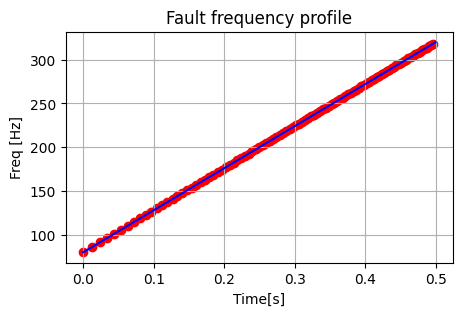

In [3]:
Ar= 1   #Amplitude
f = 2000    #Resonant Frequency in Hz
b=500       #Exponential decay factor
α=4      #Fault characteristic coeficient
fs=1e4  #Freq. Sampling

N=5000
n=np.arange(N)
t=n/fs

#fr_var=curve_rayleigh(t)
fr_var=np.linspace(20,80,N)
#fr_var=25*np.ones((N,))
f_fail=α*fr_var
ω_fail=2*np.pi*f_fail
θr_fail=np.cumsum(ω_fail)/fs

t_indexes=[]
t_impact=[]
N_of_impacts=np.int32(np.floor(np.max(θr_fail)/(2*np.pi)))+1
for i in range(N_of_impacts):
    t_index=np.argmin(np.abs(θr_fail-i*2*np.pi))
    t_indexes.append(t_index)
    t_impact.append(t[t_index])
    #print(i,t_index,t[t_index])

impacts=(np.array(t_indexes),np.array(t_impact))

%matplotlib inline
plt.figure(figsize=(5,3)) ### change tuple for better visualization or change inline for qt in %matplotlib inline 
plt.plot(t,f_fail,color='blue')
plt.title('Fault frequency profile')
plt.xlabel('Time[s]')
plt.ylabel('Freq [Hz]')
plt.grid()
plt.scatter(impacts[1],f_fail[impacts[0]],color='red',marker='o')
plt.show()

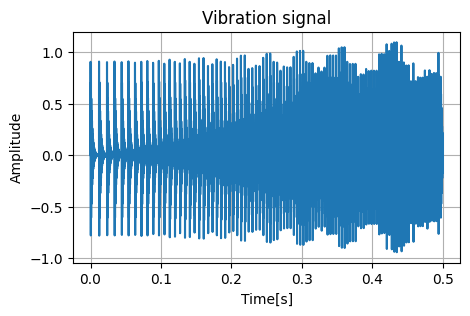

In [4]:
Sx_var=np.zeros((N,))

for r in range(len(t_impact)):
    Sx_var+=Ar*np.sin(2*np.pi*f*(n/fs-t_impact[r]))*np.exp(-b*(n/fs-t_impact[r]))*np.heaviside(n/fs-t_impact[r], 1)

%matplotlib inline
plt.figure(figsize=(5,3))
plt.plot(t,Sx_var)
plt.grid(True)
plt.title('Vibration signal')
plt.xlabel('Time[s]')
plt.ylabel('Amplitude')
#plt.savefig('Sx.pdf',bbox_inches='tight')
plt.show()

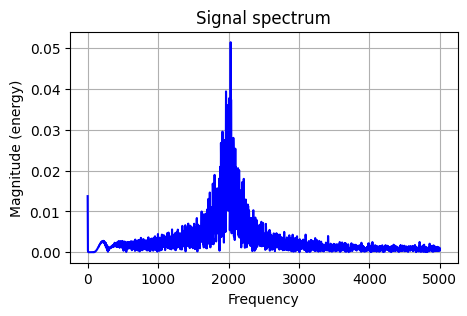

In [5]:
%matplotlib inline 
plt.figure(figsize=(5,3))
spectrum=plt.magnitude_spectrum(Sx_var, Fs=fs, color='blue')
plt.title("Signal spectrum")
plt.grid(True)
plt.show()

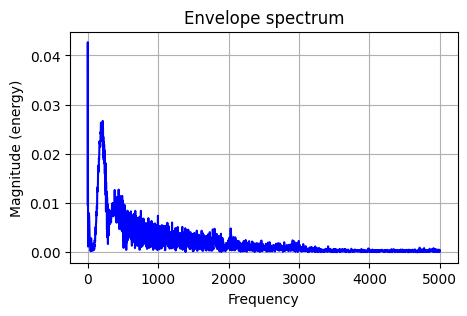

In [6]:
Sx_var_env=np.abs(signal.hilbert(Sx_var))

#%matplotlib qt 
%matplotlib inline
plt.figure(figsize=(5,3))
plt.title("Envelope spectrum")
spectrum=plt.magnitude_spectrum(Sx_var_env-np.mean(Sx_var_env), Fs=fs, color='blue')
plt.grid(True)
#plt.savefig('env_spect.pdf',bbox_inches='tight')
plt.show()

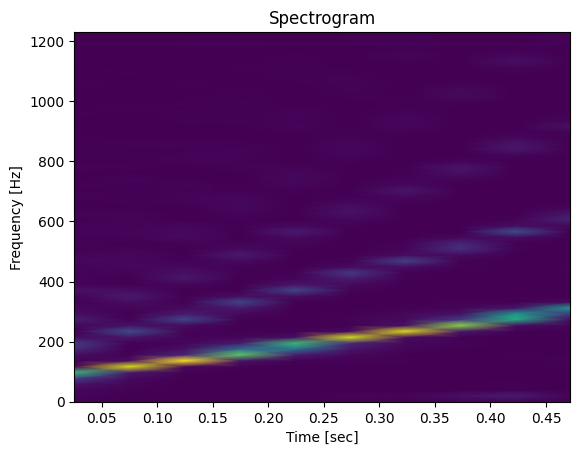

In [7]:
f_sp, t_sp, Sxx=signal.spectrogram(Sx_var_env,fs,nperseg=512,noverlap=16)
plt.pcolormesh(t_sp, f_sp[:int(len(f_sp)/4)], Sxx[:int(len(f_sp)/4),:],shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
#plt.savefig('env_spectrogram.pdf',bbox_inches='tight')
plt.show()

### General idea:

#### A bearing fault signal has spectral lines in frequencies equal to the fault times the fault characteristic coefficient.
#### The above holds in an instantaneus spectrum if rotational speed changes.
#### Use generalized demodulation (GD) to obtain a stationary spectrum like from a non-stationary bearing fault signal (under variable speed rotation conditions)
#### Knowing the way that the rotational speed varies it's posible to reconstruct an spectral line using GD.

### Steps:

* #### $f_r$ is known 
* #### Set a value for $\lambda$
* #### Calculate $s_0$ using $f=\lambda f_r$ and $f_0=\lambda f_r(0)$ [see: Vold-Kalman generalized demodulation for multi-faults detection of gear and bearing under variable speeds]
* #### Calculate the analytic signal, $x_a$, of the envelope signal 
* #### Compute the spectrum of $x_a(t)e^{-2\pi js_0(t)}$
* #### Extract the information at $f_0$

In [8]:
%matplotlib inline
plt.figure(figsize=(5,3))

λs=np.arange(1,17,1/16)
#fr=np.linspace(20,50,N)
fr=fr_var
X_f0=[]
for λ in λs:
    f_num=λ*fr
    f0=λ*fr[0]
    S0_num=np.cumsum(f_num-f0)/fs
    d_2_num=signal.hilbert(Sx_var_env)*np.exp(-1j*2*np.pi*S0_num)
    spectrum=plt.magnitude_spectrum(d_2_num, Fs=fs, color='red')
    xf0=spectrum[0][(np.fabs(spectrum[1]-f0)).argmin(axis=0)] ### aqui en rigor habría que añadir una interpolación
    X_f0.append(xf0)
    #print('λ: ', λ,'f0:',f0, 'freq',spectrum[1][(np.fabs(spectrum[1]-f0)).argmin(axis=0)],'xf0',xf0)
plt.close()

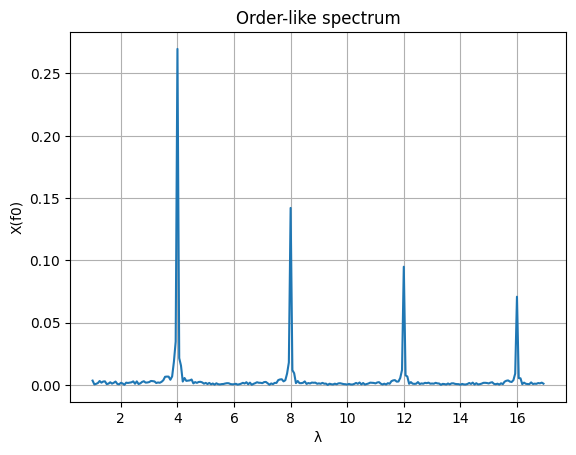

In [9]:
%matplotlib inline
plt.plot(λs,X_f0)
plt.xlabel('λ')
plt.ylabel('X(f0)')
plt.title("Order-like spectrum")
plt.grid(True)
#plt.savefig('lambda_spct.pdf',bbox_inches='tight')
plt.show()

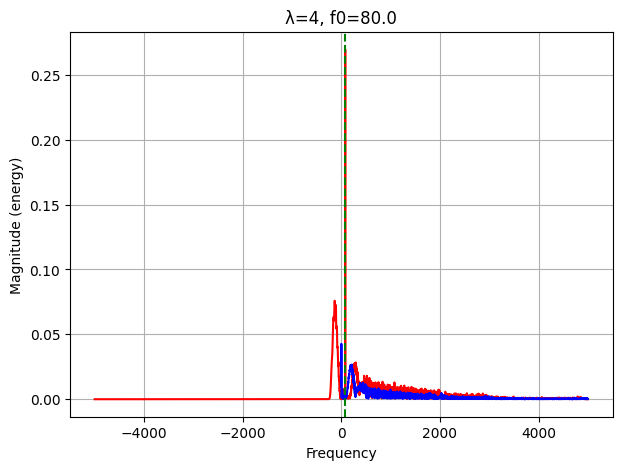

In [10]:
#%matplotlib qt

λ=4 ### change
f_num=λ*fr
f0=λ*fr[0]
S0_num=np.cumsum(f_num-f0)/fs
d_2_num=signal.hilbert(Sx_var_env)*np.exp(-1j*2*np.pi*S0_num)
plt.figure(figsize=(7,5))

spectrum=plt.magnitude_spectrum(d_2_num, Fs=fs, color='red',lw=1.5)
spectrum=plt.magnitude_spectrum(Sx_var_env-np.mean(Sx_var_env), Fs=fs, color='blue')
plt.axvline(x=f0,color='green',ls='--',lw=1.5)
plt.plot
plt.title('λ='+str(λ)+', f0='+str(f0))
plt.grid(True)